In [1]:
import h5py
import tabulate
import contextily as ctx
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from datetime import datetime, timedelta
from IPython.display import HTML, display
from os import path
from shapely.geometry import Point
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy import stats
import time
import multiprocessing
from multiprocessing import Pool

/home/liangm/.conda/envs/ea_work/lib/python3.7/site-packages/geopandas/_compat.py:53: UserWarning: The installed version of PyGEOS is too old (0.6 installed, 0.8 required), and thus GeoPandas will not use PyGEOS.
  UserWarning,


In [6]:
#load in the raster layer of WWFBIOME
from rasterio.plot import show
import rasterstats as rs
biomr = rasterio.open('ea_wwf_biomes.tif')

#load the study area aoi 
import geopandas as gpd
grsm_epsg4326=gpd.read_file("AOI/tile168062.geojson") ####!!![need to modify]!!!###  #Dodoma/Dodoma_merged4326.geojson")
print(grsm_epsg4326)


     Name                                         descriptio timestamp begin  \
0  169_51  <!-- Format: CSV (generated by convert2vector ...      None  None   

    end altitudeMo  tessellate  extrude  visibility drawOrder  icon  \
0  None       None          -1        1          -1      None  None   

                                            geometry  
0  MULTIPOLYGON Z (((41.19827 13.58943 7000.00000...  


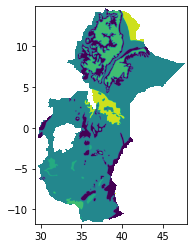

<AxesSubplot:>

In [4]:
#load in the raster layer of WWFBIOME
from rasterio.plot import show
import rasterstats as rs
biomr = rasterio.open('ea_wwf_biomes.tif')
show(biomr)

In [5]:
from glob import glob
from os import path

indir = 'l4a_orig/desa/'
outdir = 'l4a_subsets/desa'#'l4a_subsets/sub2'


alll4afiles=glob(path.join(indir, 'GEDI04_A*.h5'))
print(alll4afiles)
print(len(alll4afiles))

[]
0


In [12]:

# for infile in glob(path.join(indir, 'GEDI04_A*.h5'))[0:1]:
def extract_subset(n):
    infile = alll4afiles[n]
    print(infile)
    name, ext = path.splitext(path.basename(infile))
    subfilename = "{name}_sub{ext}".format(name=name, ext=ext)
    outfile = path.join(outdir, path.basename(subfilename))
    print(outfile)
    hf_in = h5py.File(infile, 'r')
    hf_out = h5py.File(outfile, 'w')
    
    # copy ANCILLARY and METADATA groups
    var1 = ["/ANCILLARY", "/METADATA"]
    for v in var1:
        hf_in.copy(hf_in[v],hf_out)
    
    
    print(hf_in.keys())
    # loop through BEAMXXXX groups
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            print(beam)
            # find the shots that overlays the area of interest (GRSM)
            lat = beam['lat_lowestmode'][:]
            lon = beam['lon_lowestmode'][:]
            i = np.arange(0, len(lat), 1) # index
            geo_arr = list(zip(lat,lon, i))
            l4adf = pd.DataFrame(geo_arr, columns=["lat_lowestmode", "lon_lowestmode", "i"])
#             print(l4adf)
            l4agdf = gpd.GeoDataFrame(l4adf, geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
            l4agdf.crs = "EPSG:4326"
            
            tic = time.time()
            l4agdf_gsrm = l4agdf[l4agdf['geometry'].within(grsm_epsg4326.geometry[0])]  
            toc = time.time()
            print('Done in {:.4f} seconds'.format(toc-tic))
#             print(l4agdf_gsrm)
#             print(type(l4agdf_gsrm))
            
            
#                 print("point corresponds to r, c %d, %d"%(row,col))
#                 print("raster value at point %.2f"%biomr.read(1)[row,col])
                #the extraction of wffbiome code is now done in step  3 as this step truly just handles subsetting points 
                        #to a spatial extent and not carries any attribute info 
#             tic = time.time()
#             coord_list = [(x,y) for x,y in zip(l4agdf_gsrm['geometry'].x , l4agdf_gsrm['geometry'].y)] #extract at each shot the wwfbiom code
#             l4agdf_gsrm['biome'] = [x for x in biomr.sample(coord_list)]
# #             print("nrow",l4agdf_gsrm.shape[0])
# #             with Pool(10) as p:
# #                 results  = p.map(pointextract, range(0,l4agdf_gsrm.shape[0]))
# #             print(results)
# #             l4agdf_gsrm['biome'] = results
#             toc = time.time()
#             print('Done in {:.4f} seconds'.format(toc-tic))
#             print("dimension of the subset df", l4agdf_gsrm.shape)
            indices = l4agdf_gsrm.i

            # copy BEAMS to the output file
            for key, value in beam.items():
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        group_path = value2.parent.name
                        group_id = hf_out.require_group(group_path)
                        dataset_path = group_path + '/' + key2
                        hf_out.create_dataset(dataset_path, data=value2[:][indices])
                        for attr in value2.attrs.keys():
                            hf_out[dataset_path].attrs[attr] = value2.attrs[attr]
                else:
                    group_path = value.parent.name
                    group_id = hf_out.require_group(group_path)
                    dataset_path = group_path + '/' + key
                    hf_out.create_dataset(dataset_path, data=value[:][indices])
                    for attr in value.attrs.keys():
                        hf_out[dataset_path].attrs[attr] = value.attrs[attr]

    print("done subsetting",infile)
    hf_in.close()
    hf_out.close()

In [13]:
alll4afiles=glob(path.join(indir, 'GEDI04_A*.h5'))
t=len(alll4afiles)
print(t)

63


In [14]:
def main():
    tic = time.time()
    pool = Pool(processes=10)  # set the processes max number 3
    result = pool.map(extract_subset, range(0,t))  #t
    pool.terminate()
    pool.join()
    print(result)
    print('end')
    toc = time.time()
    print('Done in {:.4f} seconds'.format(toc-tic))

    
if __name__ == "__main__":
    main()
    
    

l4a_orig/gile/GEDI04_A_2020039050942_O06555_01_T02518_02_002_02_V002.h5l4a_orig/gile/GEDI04_A_2022270083021_O21471_01_T06940_02_003_01_V002.h5l4a_orig/gile/GEDI04_A_2020337071329_O11176_01_T06787_02_002_02_V002.h5

l4a_orig/gile/GEDI04_A_2020329102010_O11054_01_T08363_02_002_02_V002.h5l4a_orig/gile/GEDI04_A_2020090085408_O07348_01_T05517_02_002_02_V002.h5l4a_orig/gile/GEDI04_A_2022041031540_O17916_01_T05517_02_003_01_V002.h5l4a_orig/gile/GEDI04_A_2021164153624_O14173_04_T08463_02_002_02_V002.h5l4a_orig/gile/GEDI04_A_2019296233551_O04892_01_T02671_02_002_02_V002.h5l4a_orig/gile/GEDI04_A_2022121192002_O19167_01_T02671_02_003_01_V002.h5
l4a_orig/gile/GEDI04_A_2021192153949_O14607_01_T01401_02_002_02_V002.h5l4a_subsets/gile2/GEDI04_A_2020039050942_O06555_01_T02518_02_002_02_V002_sub.h5
l4a_subsets/gile2/GEDI04_A_2022270083021_O21471_01_T06940_02_003_01_V002_sub.h5


l4a_subsets/gile2/GEDI04_A_2020337071329_O11176_01_T06787_02_002_02_V002_sub.h5




l4a_subsets/gile2/GEDI04_A_2020329102010_